In [1]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os

from model import *
from utils import *
import pandas as pd

import matplotlib.pyplot as plt

import scipy.io
from scipy import signal
import glob
from PIL import Image
%load_ext autoreload
%autoreload 2

In [2]:
def load_model(model, exp_name, ckpt=0, final=False, best=False, file_name=None):
    if file_name:
        fn = file_name
    elif best:
        fn = 'best-model.pth'
    elif final:
        fn = 'final-model.pth'
    else:
        fn = f'checkpoint-{ckpt}.pth'
    model_path = f'/mnt/cfs/sihaozhe/ss-dfd/exp/{exp_name}/model/{fn}'
    model_dict = torch.load(model_path)
    state_dict = model_dict['model']
    model.load_state_dict(state_dict)
    return model_dict['iter']

In [3]:
def eval_depth(pred, gt):
    error = torch.abs(gt - pred)
    AbsRel = torch.mean(error / gt)
    SqRel = torch.mean(error ** 2 / gt)
    RMSE = torch.sqrt(torch.mean(error ** 2))
    RMSE_log = torch.sqrt(torch.mean(torch.abs(torch.log10(gt+1e-8) - torch.log10(pred+1e-8)) ** 2))
    gt_pred = gt/pred
    pred_gt = pred/gt
    acc = torch.max(gt_pred, pred_gt)
    delta1 = torch.sum(acc < 1.25)/(acc.shape[-1] * acc.shape[-2])
    delta2 = torch.sum(acc < 1.25**2)/(acc.shape[-1] * acc.shape[-2])    
    delta3 = torch.sum(acc < 1.25**3)/(acc.shape[-1] * acc.shape[-2])
    return AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3

def eval_aif(inp):
    dy = inp[:, :, :, :] - F.pad(inp[:, :, :-1, :], (0, 0, 1, 0))
    dx = inp[:, :, :, :] - F.pad(inp[:, :, :, :-1], (1, 0, 0, 0))
    MG = torch.mean(torch.sqrt((dx ** 2 + dy ** 2)/2), dim=[1,2,3]) # Large -> Better
    SF = torch.sqrt(torch.mean(dx ** 2, dim=[1,2,3]) + torch.mean(dy ** 2, dim=[1,2,3])) # Large -> Better
    return MG.mean(), SF.mean()

In [4]:
def dpt_post_op(dpt, post_op, near=0.1, far=10.):
    if post_op == 'clip':
        dpt = torch.clip(dpt, 0, 1).detach().cpu()
    elif post_op == 'norm':
        dpt_local_min = torch.min(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        dpt_local_max = torch.max(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        norm_dpt_ = dpt / (dpt_local_max + 1e-8)
        # norm_dpt_ = (dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
        norm_dpt = norm_dpt_ * (far - near) + near
        dpt = norm_dpt.detach().cpu()
    return dpt

In [5]:
data_path = "/mnt/cfs/sihaozhe/data/NYUv2"
device = 0
BS = 1
use_cuda = True
torch.cuda.set_device(device)

In [6]:
orig_fd = [1, 1.5, 2.5, 4, 6]
reverse_fd = [6, 4, 2.5, 1.5, 1]
narrow_fd = [2.5, 3, 3.5, 4, 4.5]
scramble_fd = [4, 1, 2.5, 1.5, 6]
trans_fd = [2, 3, 4.5, 5, 7]

In [7]:
dataset_config = {
        'root_dir': data_path,
        'shuffle': False,
        'img_num':  5, 
        'visible_img': 5,
        'focus_dist': orig_fd,
        'recon_all': True,
        'RGBFD': True,
        'DPT': True,
        'AIF': True,
        'near': 0.1,
        'far':10.,
        'scale':1,
        'trans': False
    }

In [8]:
camera = ThinLenCamera(fnumber=1.2, focal_length=17*1e-3, pixel_size=1.2e-5)
render = GaussPSF(7)
render.cuda()
model = FUNet(4, 4)

In [9]:
ckpt = 1500
final = False
best=True
post_op = 'norm'
model_name = 'NYU_100_unsup_full'
upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

In [10]:
exp_name = f'{model_name}'
n_iter = load_model(model, exp_name, ckpt, best=best)
model = model.cuda()

### FD-DS Ablation

5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654
5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654
5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654
5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


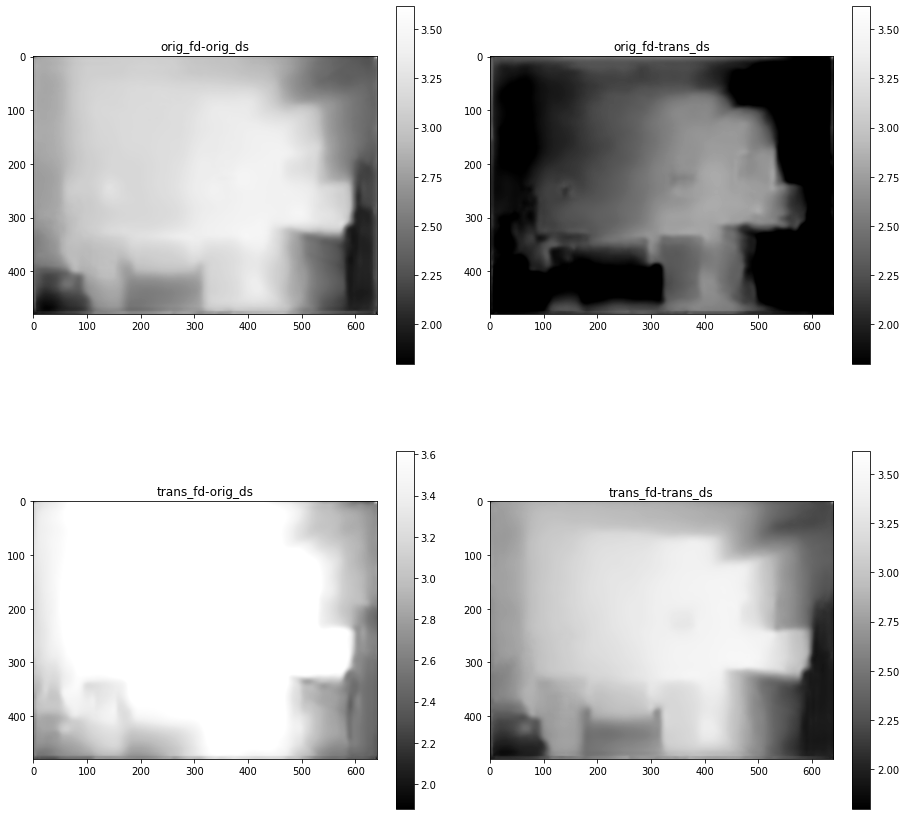

In [42]:
plt.figure(figsize=(15, 15))
for i, fd in enumerate([orig_fd, trans_fd]):
    for j, trans in enumerate([False, True]):
        dataset_config.update(focus_dist=fd, trans=trans)
        train_dl, _, test_dl = load_data(dataset_config, "NYUv2", BS)
        dl = iter(test_dl)
        batch = next(dl)
        with torch.no_grad():
            raw_aif_dpt = model(batch['rgb_fd'].cuda())
            raw_aif = raw_aif_dpt[:, :-1]
            raw_dpt = raw_aif_dpt[:, -1]
        pred_dpt = dpt_post_op(raw_dpt, post_op)
        pred_dpt = upsample(pred_dpt.unsqueeze(0)).squeeze(0)
        pred_aif = torch.clip(raw_aif, 0, 1)
        dpt_gt = batch['dpt'][0]
        aif_gt = batch['aif']
        plt.subplot(2, 2, i * 2 + j +1)
        if i == 0:
            setting = 'orig_fd'
            near = dpt_gt[0].min()
        else:
            setting = 'trans_fd'
            near = dpt_gt[0].min()
        if j == 0:
            setting += '-orig_ds'
        else:
            setting += '-trans_ds'
        plt.title(setting)
        plt.imshow(np.clip(pred_dpt[0].cpu().numpy(), near, dpt_gt[0].max()), cmap='Greys_r')
        plt.colorbar(fraction=0.047)
# plt.savefig('ds_fd_ablation_1.png')

### Different FD

5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654
5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654
5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654
5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


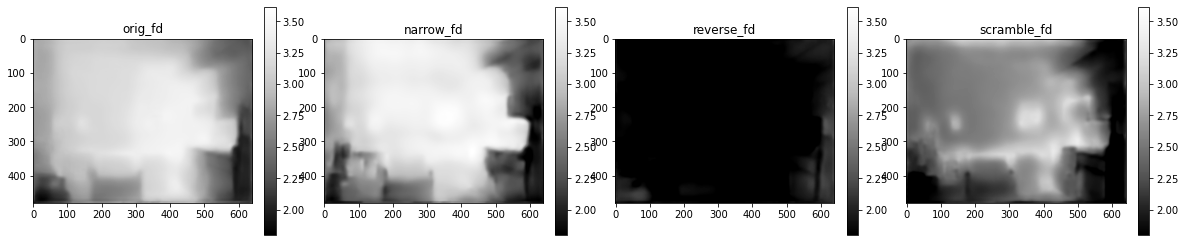

In [43]:
plt.figure(figsize=(20, 10))
for i, fd in enumerate([orig_fd, narrow_fd, reverse_fd, scramble_fd]):
    dataset_config.update(focus_dist=fd, trans=False)
    train_dl, _, test_dl = load_data(dataset_config, "NYUv2", BS)
    dl = iter(test_dl)
    batch = next(dl)
    with torch.no_grad():
        raw_aif_dpt = model(batch['rgb_fd'].cuda())
        raw_aif = raw_aif_dpt[:, :-1]
        raw_dpt = raw_aif_dpt[:, -1]
    pred_dpt = dpt_post_op(raw_dpt, post_op)
    pred_dpt = upsample(pred_dpt.unsqueeze(0)).squeeze(0)
    pred_aif = torch.clip(raw_aif, 0, 1)
    dpt_gt = batch['dpt'][0]
    aif_gt = batch['aif']
    plt.subplot(1, 4, i +1)
    if i == 0:
        setting = 'orig_fd'
    elif i == 1:
        setting = 'narrow_fd'
    elif i == 2:
        setting = 'reverse_fd'
    else:
        setting = 'scramble_fd'
    plt.title(setting)
    plt.imshow(np.clip(pred_dpt[0].cpu().numpy(), dpt_gt[0].min(), dpt_gt[0].max()), cmap='Greys_r')
    plt.colorbar(fraction=0.047)

### Single Image

5 out of 5 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


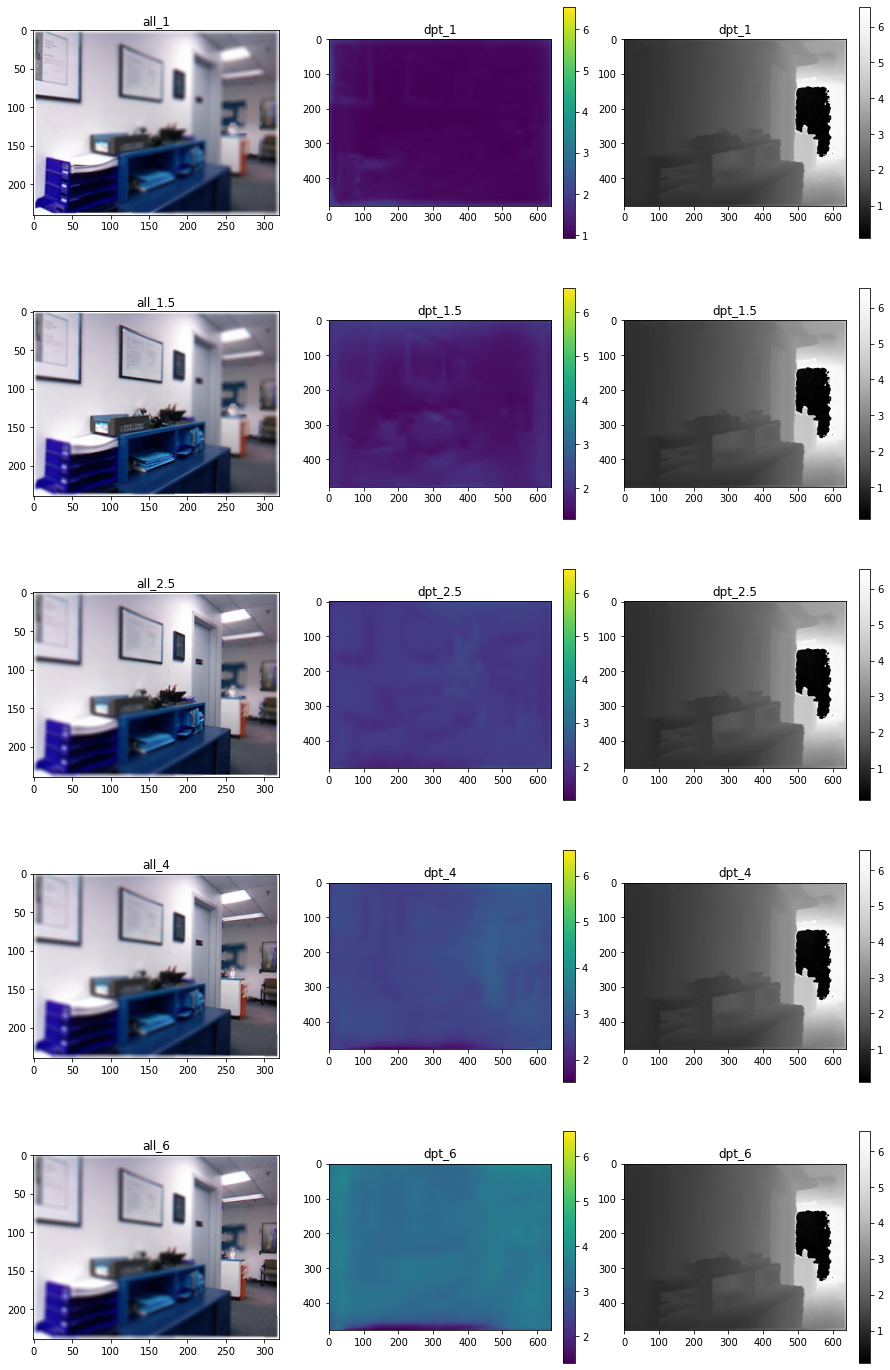

In [44]:

plt.figure(figsize=(15, 25))
for fd in [orig_fd]:
    dataset_config.update(focus_dist=fd, trans=False)
    train_dl, _, test_dl = load_data(dataset_config, "NYUv2", BS)
    dl = iter(test_dl)
    batch = next(dl)
    batch = next(dl)
    batch = next(dl)
    
    for j in range(5):
        with torch.no_grad():
            raw_aif_dpt = model(batch['rgb_fd'][:, j, None].cuda())
            raw_aif = raw_aif_dpt[:, :-1]
            raw_dpt = raw_aif_dpt[:, -1]
        pred_dpt = dpt_post_op(raw_dpt, post_op)
        pred_dpt = upsample(pred_dpt.unsqueeze(0)).squeeze(0)
        pred_aif = torch.clip(raw_aif, 0, 1)
        dpt_gt = batch['dpt'][0]
        aif_gt = batch['aif']
        plt.subplot(5, 3, j * 3 + 1)
        plt.title(f'all_{fd[j]}')
        plt.imshow(batch['output'][0, j].numpy().transpose(1, 2, 0))
        plt.subplot(5, 3, j * 3 + 2)
        plt.title(f'dpt_{fd[j]}')
        plt.imshow(np.clip(pred_dpt[0].cpu().numpy(), dpt_gt[0].min(), dpt_gt[0].max()))
        plt.colorbar(fraction=0.047)        
        plt.subplot(5, 3, j * 3 + 3)
        plt.title(f'dpt_{fd[j]}')
        plt.imshow(dpt_gt[0].numpy(), cmap='Greys_r')
        plt.colorbar(fraction=0.047)

### Bold Test

In [11]:
name = 'yingbi'
data_dir = f"/mnt/cfs/zhaobin/DFD/data/{name}X10"
sigma_fn = "sharps.mat"
aif_fn = "AIF.bmp"
depth_fn = 'depth.mat'
img_list = glob.glob(os.path.join(data_dir, '*.bmp'))
index = 150
img_list = sorted(img_list, key=lambda x: (x.split('/')[-1][:-4]).zfill(3))
aif = img_list.pop(-1)
n_img = len(img_list)

In [12]:
img_inp = []
for index in trange(80, 180, 10):
    im = Image.open(os.path.join(img_list[index]))
    img_all = np.array(im)[::4, ::4][:512, -512:]
    mat_all = (img_all.copy() / 255.).astype(np.float32)
    mat_all = np.repeat(mat_all[None], 3, axis=0)
    mat_all = torch.from_numpy(mat_all).unsqueeze(0)
    mat_fd = torch.tensor([index/200]).view(-1, 1, 1, 1).expand_as(mat_all[:, 0, None])
    mat_all = torch.cat([mat_all, mat_fd], axis=1)
    img_inp.append(mat_all)
img_inp = torch.cat(img_inp)

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
inp = img_inp.unsqueeze(0)

In [14]:
with torch.no_grad():
    raw_rgbd = model(inp.cuda())
    raw_aif = raw_rgbd[:, :-1]
    raw_dpt = raw_rgbd[:, -1]
pred_dpt = dpt_post_op(raw_dpt, 'raw')

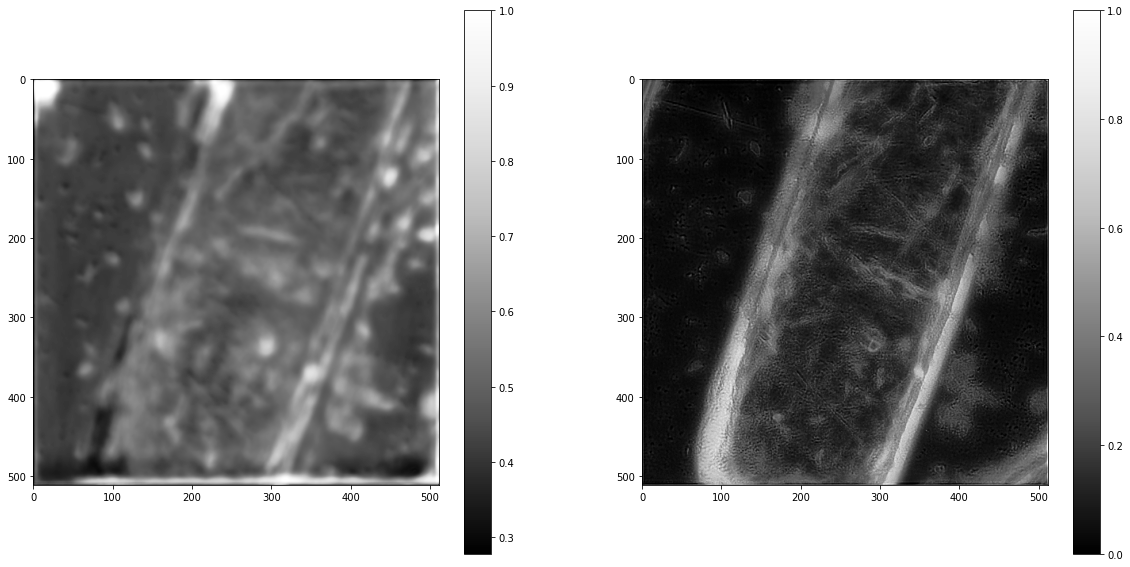

In [15]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.clip(pred_dpt[0].cpu().numpy(), 0., 1), cmap='Greys_r')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.clip(raw_aif[0].cpu().numpy(), 0, 1).transpose(1, 2, 0)[:, :, -2], cmap='Greys_r')
plt.colorbar()

In [16]:
img_inp = []
for index in trange(200):
    im = Image.open(os.path.join(img_list[index]))
    img_all = np.array(im)[::4, ::4][:512, -512:]
    mat_all = (img_all.copy() / 255.).astype(np.float32)
    mat_all = np.repeat(mat_all[None], 3, axis=0)
    mat_all = torch.from_numpy(mat_all).unsqueeze(0)
    mat_fd = torch.tensor([0]).view(-1, 1, 1, 1).expand_as(mat_all[:, 0, None])
    mat_all = torch.cat([mat_all, mat_fd], axis=1)
    img_inp.append(mat_all)
img_inp = torch.cat(img_inp)

  0%|          | 0/200 [00:00<?, ?it/s]

In [17]:
pred_dpts = []
for img in img_inp:
    img = img.view(1, 1, *img.shape)
    with torch.no_grad():
        raw_rgbd = model(img.cuda())
        raw_aif = raw_rgbd[:, :-1]
        raw_dpt = raw_rgbd[:, -1]
    pred_dpt = dpt_post_op(raw_dpt, 'raw')
    pred_dpts.append(pred_dpt)

In [19]:
pred_dpts = torch.cat(pred_dpts, dim=0)

In [37]:
norm_pred_dpts = (pred_dpts - torch.min(pred_dpts, dim=0)[0].unsqueeze(0)) / (torch.max(pred_dpts, dim=0)[0].unsqueeze(0) - torch.min(pred_dpts, dim=0)[0].unsqueeze(0))

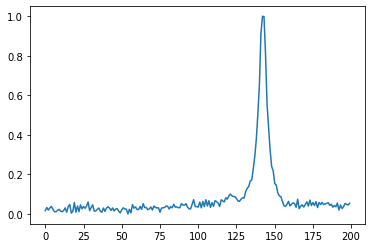

In [38]:
plt.plot(np.arange(200), norm_pred_dpts[:, 255, 255].cpu().numpy())

In [108]:
win_size = 5
avg_win = np.array([1/win_size] * win_size)
torch_avg_win = torch.from_numpy(avg_win).type(torch.float32)

In [176]:
torch_avg_win

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [111]:
sm_response = signal.convolve(norm_pred_dpts[100:, 100, 50].cpu().numpy(), avg_win, mode='valid')

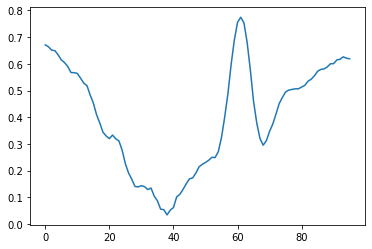

In [112]:
plt.plot(np.arange(len(sm_response)), sm_response)

In [204]:
sm_pred_dpts = norm_pred_dpts.transpose(0, 2).reshape(-1, 200)
sm_pred_dpts = F.conv1d(sm_pred_dpts.unsqueeze(1), torch_avg_win.view(1, 1, win_size).cuda())
sm_pred_dpts = sm_pred_dpts.squeeze().reshape(512, 512, -1).transpose(0, 2)
sm_pred_dpts.shape

torch.Size([196, 512, 512])

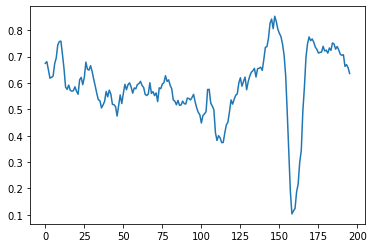

In [206]:
plt.plot(np.arange(196), sm_pred_dpts[:, 300, 0].cpu().numpy())

In [209]:
max_idx = torch.max(pred_dpts, dim=0)[1]
max_idx_np = max_idx.cpu().numpy()

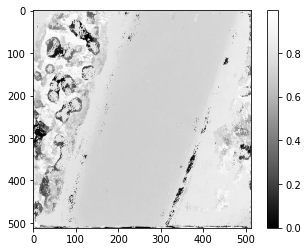

In [210]:
plt.imshow(max_idx_np/200, cmap="Greys_r")
plt.colorbar()

In [199]:
sm_max_idx_np = torch.max(sm_pred_dpts, dim=0)[1]
sm_max_idx_np = sm_max_idx.cpu().numpy()

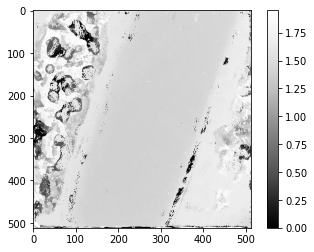

In [201]:
plt.imshow(sm_max_idx_np/100, cmap="Greys_r")
plt.colorbar()

(array([7.00000e+00, 3.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 3.00000e+00, 1.00000e+00, 7.00000e+00, 6.00000e+00,
        1.20000e+01, 4.00000e+00, 7.00000e+00, 9.60000e+01, 4.77350e+04,
        1.08830e+04, 3.06060e+04, 3.56100e+03, 8.50000e+01, 1.69121e+05]),
 array([  0.  ,   9.95,  19.9 ,  29.85,  39.8 ,  49.75,  59.7 ,  69.65,
         79.6 ,  89.55,  99.5 , 109.45, 119.4 , 129.35, 139.3 , 149.25,
        159.2 , 169.15, 179.1 , 189.05, 199.  ]),
 <BarContainer object of 20 artists>)

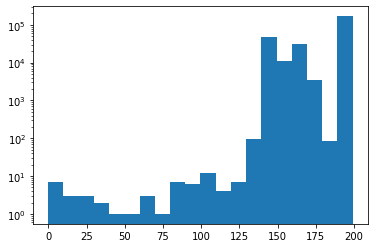

In [148]:
plt.hist(max_idx.flatten().cpu().numpy(), bins=20, log=True)

In [108]:
inputs = torch.randn(33, 16, 30)
filters = torch.randn(20, 16, 5)
F.conv1d(inputs, filters).shape

torch.Size([33, 20, 26])

In [67]:
confidence = (1-torch.mean(norm_pred_dpts,dim=0))/torch.mean(norm_pred_dpts,dim=0)
confidenceNormal = (confidence-torch.min(confidence))/(torch.max(confidence)-torch.min(confidence))
confidenceNormal = confidenceNormal.cpu().numpy()

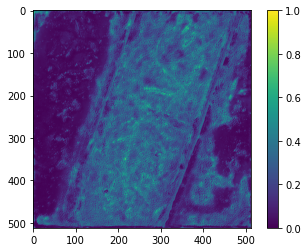

In [68]:
plt.imshow(confidenceNormal)
plt.colorbar()

In [83]:
N, W, H = norm_pred_dpts.shape
Ind2Sigmas = np.zeros((W, H, N))
for n in range(N):
    Ind2Sigmas[:, :, n] = n + 1
SigmaOrig = norm_pred_dpts.cpu().numpy().transpose(1, 2, 0)

In [84]:
SigmaOrig.shape

(512, 512, 200)

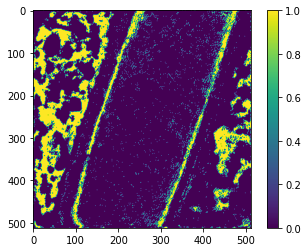

In [97]:
mask = norm_pred_dpts.cpu().numpy().transpose(1, 2, 0) > 0.8
plt.imshow(mask[:, :, 150])
plt.colorbar()

In [91]:
Ind2Sigmas = Ind2Sigmas * mask
Ind2Sigmas[Ind2Sigmas==0] = None

In [92]:
Maxpo = np.max(np.nan_to_num(Ind2Sigmas, nan=-np.inf), axis=-1).astype(int)
Minpo = np.min(np.nan_to_num(Ind2Sigmas, nan=np.inf), axis=-1).astype(int)

In [95]:
MinS = np.min(SigmaOrig, axis=-1)
MaxS = np.max(SigmaOrig, axis=-1)
Depth = np.argmax(SigmaOrig, axis=-1)

In [96]:
for i in range(W):
    for j in range(H):
        if Maxpo[i, j] == Depth[i, j] and Maxpo[i, j] != N-1:
            mask[i, j, Maxpo[i, j] + 1] = 1
        if Minpo[i, j] == Depth[i, j] and Minpo[i, j] != 0:
            mask[i, j, Minpo[i, j] - 1] = 1